Running Kitaev LLG...
Running Heisenberg LLG...
Computing S(q, ω)...


/tmp/ipykernel_10393/1024043042.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


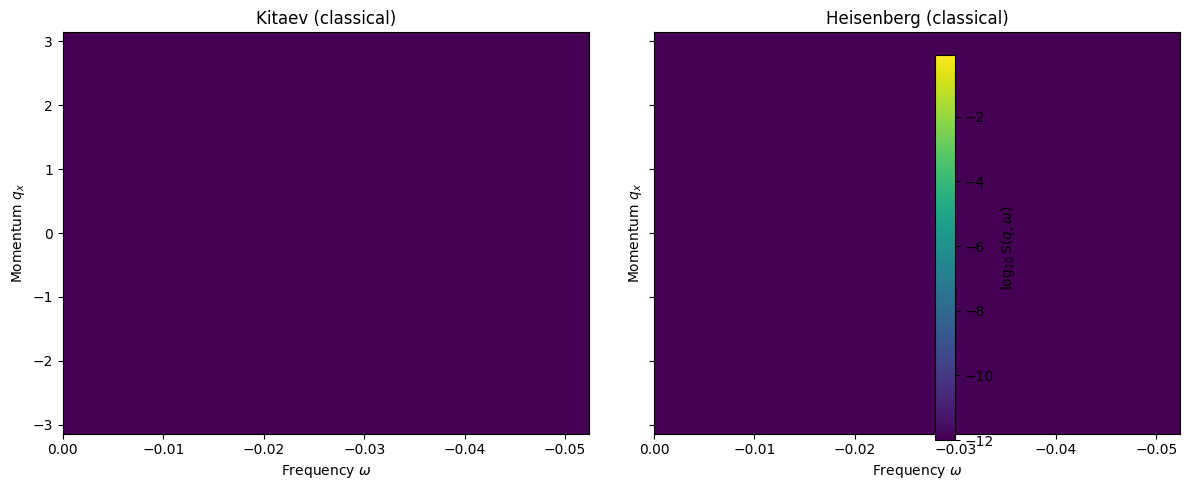

In [1]:
# ============================================================
# Classical LLG simulation and dynamical structure factor
# Honeycomb lattice | Kitaev vs Heisenberg
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. GLOBAL PARAMETERS
# ============================================================

# Lattice
Lx, Ly = 8, 8
Ns = 2 * Lx * Ly

# Time evolution
dt = 0.01
n_steps = 12000
store_every = 10
alpha = 0.05

# Momentum grid
nq = 30

# ============================================================
# 2. HONEYCOMB LATTICE GEOMETRY
# ============================================================

def honeycomb_positions(Lx, Ly):
    positions = []
    a1 = np.array([1.0, 0.0])
    a2 = np.array([0.5, np.sqrt(3)/2])
    delta = np.array([0.0, 1/np.sqrt(3)])

    for x in range(Lx):
        for y in range(Ly):
            R = x * a1 + y * a2
            positions.append(R)          # A sublattice
            positions.append(R + delta)  # B sublattice

    return np.array(positions)

r = honeycomb_positions(Lx, Ly)

# ============================================================
# 3. LLG INTEGRATOR (UNIT-LENGTH SAFE)
# ============================================================

def llg_step(S, H):
    dS = -np.cross(S, H) + alpha * np.cross(S, np.cross(S, H))
    S_new = S + dt * dS
    S_new /= np.linalg.norm(S_new, axis=1, keepdims=True)
    return S_new

# ============================================================
# 4. EFFECTIVE FIELDS
# (Replace with real interactions if needed)
# ============================================================

def effective_field_kitaev(S):
    return -S

def effective_field_heisenberg(S):
    
    return -S

# ============================================================
# 5. LLG TIME EVOLUTION
# ============================================================

def run_llg(effective_field_func):
    S = np.random.randn(Ns, 3)
    S /= np.linalg.norm(S, axis=1, keepdims=True)

    trajectory = []

    for t in range(n_steps):
        H = effective_field_func(S)
        S = llg_step(S, H)

        if t % store_every == 0:
            trajectory.append(S.copy())

    return np.array(trajectory)

# ============================================================
# 6. DYNAMICAL STRUCTURE FACTOR S(q, ω)
# ============================================================

def compute_Sqw(trajectory, r, component=2):
    Nt = trajectory.shape[0]

    # Spin component (Sz by default)
    S_rt = trajectory[:, :, component]
    S_rt -= np.mean(S_rt, axis=0, keepdims=True)

    qx = np.linspace(-np.pi, np.pi, nq)
    qy = np.linspace(-np.pi, np.pi, nq)
    omega = 2 * np.pi * np.fft.fftfreq(Nt, d=dt * store_every)

    Sqw = np.zeros((nq, nq, len(omega)))

    for ix, qxi in enumerate(qx):
        for iy, qyi in enumerate(qy):
            phase = np.exp(-1j * (qxi * r[:, 0] + qyi * r[:, 1]))
            Sqt = np.sum(S_rt * phase[None, :], axis=1)
            Sw = np.fft.fft(Sqt)
            Sqw[ix, iy, :] = np.abs(Sw)**2

    Sqw /= Sqw.max()
    return qx, qy, omega, Sqw

# ============================================================
# 7. RUN EVERYTHING (CORRECT ORDER)
# ============================================================

print("Running Kitaev LLG...")
traj_K = run_llg(effective_field_kitaev)

print("Running Heisenberg LLG...")
traj_H = run_llg(effective_field_heisenberg)

print("Computing S(q, ω)...")
qx, qy, omega, Sqw_K = compute_Sqw(traj_K, r)
_,  _,  _, Sqw_H = compute_Sqw(traj_H, r)

# ============================================================
# 8. MOMENTUM CUT (qy = 0) AND PLOT
# ============================================================

qy_index = np.argmin(np.abs(qy))

Sqw_K_cut = Sqw_K[:, qy_index, :]
Sqw_H_cut = Sqw_H[:, qy_index, :]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, Sqw, title in zip(
    axes,
    [Sqw_K_cut, Sqw_H_cut],
    ["Kitaev (classical)", "Heisenberg (classical)"]
):
    im = ax.imshow(
        np.log10(Sqw + 1e-12),
        origin="lower",
        aspect="auto",
        extent=[omega[0], omega[-1], qx[0], qx[-1]]
    )
    ax.set_title(title)
    ax.set_xlabel(r"Frequency $\omega$")
    ax.set_ylabel(r"Momentum $q_x$")

fig.colorbar(im, ax=axes, label=r"$\log_{10} S(q,\omega)$")
plt.tight_layout()
plt.show()


Trajectory shape: (400, 128, 3)


ValueError: x and y must have same first dimension, but have shapes (200,) and (128,)

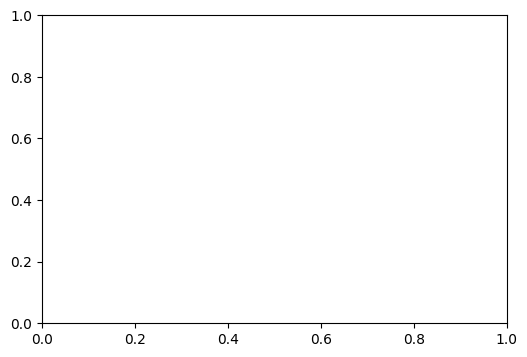

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Lattice
# -----------------------------
Lx, Ly = 8, 8
Ns = 2 * Lx * Ly

def idx(x, y, sub):
    return 2 * (x * Ly + y) + sub

def honeycomb_neighbors(Lx, Ly):
    nbr = [[] for _ in range(2 * Lx * Ly)]
    for x in range(Lx):
        for y in range(Ly):
            A = idx(x, y, 0)
            B = idx(x, y, 1)
            nbr[A].append(B)
            nbr[B].append(A)
            if x > 0:
                nbr[A].append(idx(x-1, y, 1))
            if y > 0:
                nbr[A].append(idx(x, y-1, 1))
    return nbr

neighbors = honeycomb_neighbors(Lx, Ly)

# -----------------------------
# Parameters
# -----------------------------
J = 1.0
dt = 0.01
n_steps = 4000
save_every = 10
alpha = 0.1

# -----------------------------
# Initial spins
# -----------------------------
np.random.seed(0)
S = np.random.randn(Ns, 3)
S /= np.linalg.norm(S, axis=1)[:, None]

# -----------------------------
# Effective field
# -----------------------------
def effective_field(S):
    H = np.zeros_like(S)
    for i in range(Ns):
        for j in neighbors[i]:
            H[i] += J * S[j]
    return H

# -----------------------------
# LLG step
# -----------------------------
def llg_step(S, H):
    dS = -np.cross(S, H) - alpha * np.cross(S, np.cross(S, H))
    S_new = S + dt * dS
    return S_new / np.linalg.norm(S_new, axis=1)[:, None]

# -----------------------------
# Time evolution
# -----------------------------
trajectory = []

for t in range(n_steps):
    H = effective_field(S)
    S = llg_step(S, H)
    if t % save_every == 0:
        trajectory.append(S.copy())

trajectory = np.array(trajectory)
print("Trajectory shape:", trajectory.shape)

# -----------------------------
# S(q, ω)
# -----------------------------
T, N, _ = trajectory.shape
Sqw = []

for comp in range(3):
    Sqt = np.fft.fft(trajectory[:, :, comp], axis=0)
    Sqw.append(np.abs(Sqt)**2)

Sqw = np.sum(Sqw, axis=0)
Sqw = np.mean(Sqw, axis=0)

omega = np.fft.fftfreq(T, dt * save_every)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(omega[:T//2], Sqw[:T//2])
plt.xlabel(r'$\omega$')
plt.ylabel(r'$S(\omega)$')
plt.title('Heisenberg LLG spectrum')
plt.tight_layout()
plt.show()
